<a href="https://colab.research.google.com/github/Cyro56/Colabora-o_Minerva-Rockets/blob/main/docs/notebooks/getting_started_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started - RocketPy in Colab

We start by setting up our environment. To run this notebook, we will need:


*   RocketPy
*   netCDF4 (to get weather forecasts)
*   Data files (we will clone RocketPy's repository for these)

Therefore, let's run the following lines of code:

In [1]:
!pip install rocketpy netCDF4
!git clone https://github.com/giovaniceotto/RocketPy.git

     |████████████████████████████████| 83 kB 1.4 MB/s 
Cloning into 'RocketPy'...
remote: Enumerating objects: 1567, done.
remote: Counting objects: 100% (756/756), done.
remote: Compressing objects: 100% (501/501), done.
remote: Total 1567 (delta 433), reused 510 (delta 238), pack-reused 811
Receiving objects: 100% (1567/1567), 410.57 MiB | 29.51 MiB/s, done.
Resolving deltas: 100% (910/910), done.
Checking out files: 100% (119/119), done.


In [2]:
import os
os.chdir('RocketPy/docs/notebooks')

Now we can start!

Here we go through a simplified rocket trajectory simulation to get you started. Let's start by importing the rocketpy module.

In [3]:
from rocketpy import Environment, SolidMotor, Rocket, Flight

If you are using Jupyter Notebooks, it is recommended to run the following line to make matplotlib plots which will be shown later interactive and higher quality.

In [4]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

## Setting Up a Simulation

### Creating an Environment for Spaceport America

In [5]:
Env = Environment(
    railLength=5.2,
    latitude=32.990254,
    longitude=-106.974998,
    elevation=1400
) 

To get weather data from the GFS forecast, available online, we run the following lines.

First, we set tomorrow's date.

In [6]:
import datetime

tomorrow = datetime.date.today() + datetime.timedelta(days=1)

Env.setDate((tomorrow.year, tomorrow.month, tomorrow.day, 12)) # Hour given in UTC time

Then, we tell Env to use a GFS forecast to get the atmospheric conditions for flight.

Don't mind the warning, it just means that not all variables, such as wind speed or atmospheric temperature, are available at all altitudes given by the forecast.

In [7]:
Env.setAtmosphericModel(type='Forecast', file='GFS')

We can see what the weather will look like by calling the info method!

Launch Site Details

Launch Rail Length:  5.2  m
Launch Date:  2021-10-09 12:00:00  UTC
Launch Site Latitude: 32.99025°
Launch Site Longitude: -106.97500°
Reference Datum: SIRGAS2000
Launch Site UTM coordinates: 315468.64 W    3651938.65 N
Launch Site UTM zone: 13S
Launch Site Surface Elevation: 1471.5 m


Atmospheric Model Details

Atmospheric Model Type:  Forecast
Forecast Maximum Height: 79.321 km
Forecast Time Period: From  2021-10-08 12:00:00  to  2021-10-24 12:00:00  UTC
Forecast Hour Interval:  3  hrs
Forecast Latitude Range: From  -90.0 ° To  90.0 °
Forecast Longitude Range: From  0.0 ° To  359.75 °


Surface Atmospheric Conditions

Surface Wind Speed: 3.30 m/s
Surface Wind Direction: 183.80°
Surface Wind Heading: 23.39°
Surface Pressure: 852.72 hPa
Surface Temperature: 293.57 K
Surface Air Density: 1.012 kg/m³
Surface Speed of Sound: 343.48 m/s


Atmospheric Model Plots


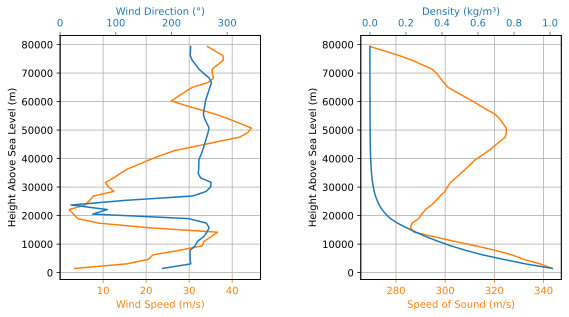

In [8]:
Env.info()

### Creating a Motor

A solid rocket motor is used in this case. To create a motor, the SolidMotor class is used and the required arguments are given.

The SolidMotor class requires the user to have a thrust curve ready. This can come either from a .eng file for a commercial motor, such as below, or a .csv file from a static test measurement.

Besides the thrust curve, other parameters such as grain properties and nozzle dimensions must also be given.

In [9]:
Pro75M1670 = SolidMotor(
    thrustSource="../../data/motors/Cesaroni_M1670.eng",
    burnOut=3.9,
    grainNumber=5,
    grainSeparation=5/1000,
    grainDensity=1815,
    grainOuterRadius=33/1000,
    grainInitialInnerRadius=15/1000,
    grainInitialHeight=120/1000,
    nozzleRadius=33/1000,
    throatRadius=11/1000,
    interpolationMethod='linear'
)

To see what our thrust curve looks like, along with other import properties, we invoke the info method yet again. You may try the allInfo method if you want more information all at once!

In [ ]:
Pro75M1670.info()

### Creating a Rocket

A rocket is composed of several components. Namely, we must have a motor (good thing we have the Pro75M1670 ready), a couple of aerodynamic surfaces (nose cone, fins and tail) and parachutes (if we are not launching a missile).

Let's start by initializing our rocket, named Calisto, supplying it with the Pro75M1670 engine, entering its inertia properties, some dimensions and also its drag curves.

In [10]:
Calisto = Rocket(
    motor=Pro75M1670,
    radius=127/2000,
    mass=19.197-2.956,
    inertiaI=6.60,
    inertiaZ=0.0351,
    distanceRocketNozzle=-1.255,
    distanceRocketPropellant=-0.85704,
    powerOffDrag='../../data/calisto/powerOffDragCurve.csv',
    powerOnDrag='../../data/calisto/powerOnDragCurve.csv'
)

Calisto.setRailButtons([0.2, -0.5])

#### Adding Aerodynamic Surfaces

Now we define the aerodynamic surfaces. They are really straight forward.

In [11]:
NoseCone = Calisto.addNose(length=0.55829, kind="vonKarman", distanceToCM=0.71971)

FinSet = Calisto.addFins(4, span=0.100, rootChord=0.120, tipChord=0.040, distanceToCM=-1.04956)

Tail = Calisto.addTail(topRadius=0.0635, bottomRadius=0.0435, length=0.060, distanceToCM=-1.194656)

#### Adding Parachutes

Finally, we have parachutes! Calisto will have two parachutes, Drogue and Main.

Both parachutes are activated by some special algorithm, which is usually really complex and a trade secret. Most algorithms are based on pressure sampling only, while some also use acceleration info.

RocketPy allows you to define a trigger function which will decide when to activate the ejection event for each parachute. This trigger function is supplied with pressure measurement at a predefined sampling rate. This pressure signal is usually noisy, so artificial noise parameters can be given. Call help(Rocket.addParachute) for more details. Furthermore, the trigger function also recieves the complete state vector of the rocket, allowing us to use velocity, acceleration or even attitude to decide when the parachute event should be triggered.

Here, we define our trigger functions rather simply using Python. However, you can call the exact code which will fly inside your rocket as well.

In [12]:
def drogueTrigger(p, y):
    # p = pressure
    # y = [x, y, z, vx, vy, vz, e0, e1, e2, e3, w1, w2, w3]
    # activate drogue when vz < 0 m/s.
    return True if y[5] < 0 else False

def mainTrigger(p, y):
    # p = pressure
    # y = [x, y, z, vx, vy, vz, e0, e1, e2, e3, w1, w2, w3]
    # activate main when vz < 0 m/s and z < 800 + 1400 m (+1400 due to surface elevation).
    return True if y[5] < 0 and y[2] < 800+1400 else False

Main = Calisto.addParachute('Main',
                            CdS=10.0,
                            trigger=mainTrigger, 
                            samplingRate=105,
                            lag=1.5,
                            noise=(0, 8.3, 0.5))

Drogue = Calisto.addParachute('Drogue',
                              CdS=1.0,
                              trigger=drogueTrigger, 
                              samplingRate=105,
                              lag=1.5,
                              noise=(0, 8.3, 0.5))

Just be careful if you run this last cell multiple times! If you do so, your rocket will end up with lots of parachutes which activate together, which may cause problems during the flight simulation. We advise you to re-run all cells which define our rocket before running this, preventing unwanted old parachutes. Alternatively, you can run the following lines to remove parachutes.

```python
Calisto.parachutes.remove(Drogue)
Calisto.parachutes.remove(Main)
```

## Simulating a Flight

Simulating a flight trajectory is as simples as initializing a Flight class object givin the rocket and environement set up above as inputs. The launch rail inclination and heading are also given here.

In [13]:
TestFlight = Flight(rocket=Calisto, environment=Env, inclination=85, heading=0)

## Analysing the Results

RocketPy gives you many plots, thats for sure! They are divided into sections to keep them organized. Alternatively, see the Flight class documentation to see how to get plots for specific variables only, instead of all of them at once.

Initial Conditions

Position - x: 0.00 m | y: 0.00 m | z: 1471.47 m
Velocity - Vx: 0.00 m/s | Vy: 0.00 m/s | Vz: 0.00 m/s
Attitude - e0: 0.999 | e1: -0.044 | e2: -0.000 | e3: 0.000
Euler Angles - Spin φ : 0.00° | Nutation θ: -5.00° | Precession ψ: 0.00°
Angular Velocity - ω1: 0.00 rad/s | ω2: 0.00 rad/s| ω3: 0.00 rad/s


Launch Rail Orientation

Launch Rail Inclination: 85.00°
Launch Rail Heading: 0.00°


Surface Wind Conditions

Frontal Surface Wind Speed: 3.29 m/s
Lateral Surface Wind Speed: -0.22 m/s


 Rail Departure State

Rail Departure Time: 0.363 s
Rail Departure Velocity: 25.800 m/s
Rail Departure Static Margin: 2.133 c
Rail Departure Angle of Attack: 7.334°
Rail Departure Thrust-Weight Ratio: 10.143
Rail Departure Reynolds Number: 1.820e+05


BurnOut State

BurnOut time: 3.900 s
Altitude at burnOut: 660.754 m (AGL)
Rocket velocity at burnOut: 280.885 m/s
Freestream velocity at burnOut: 281.106 m/s
Mach Number at burnOut: 0.821
Kinetic energy at burnOut: 6.407e+05 J


Apogee



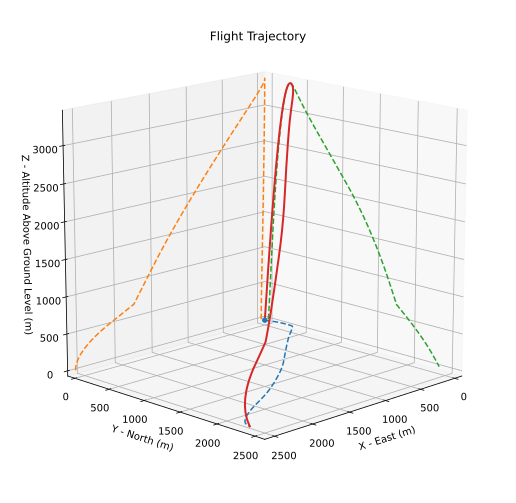



Trajectory Kinematic Plots



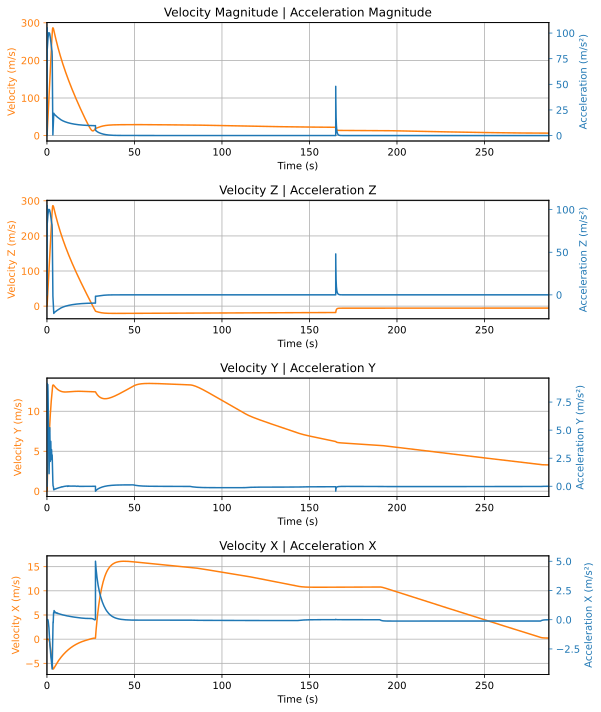



Angular Position Plots



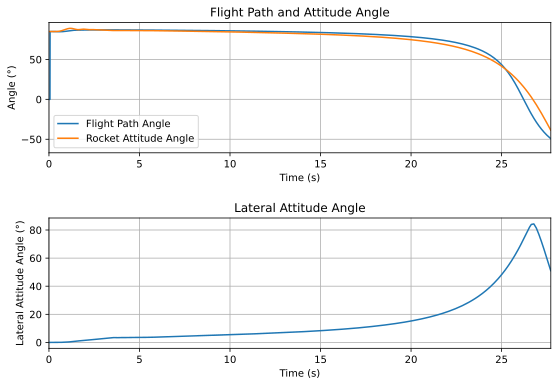



Path, Attitude and Lateral Attitude Angle plots



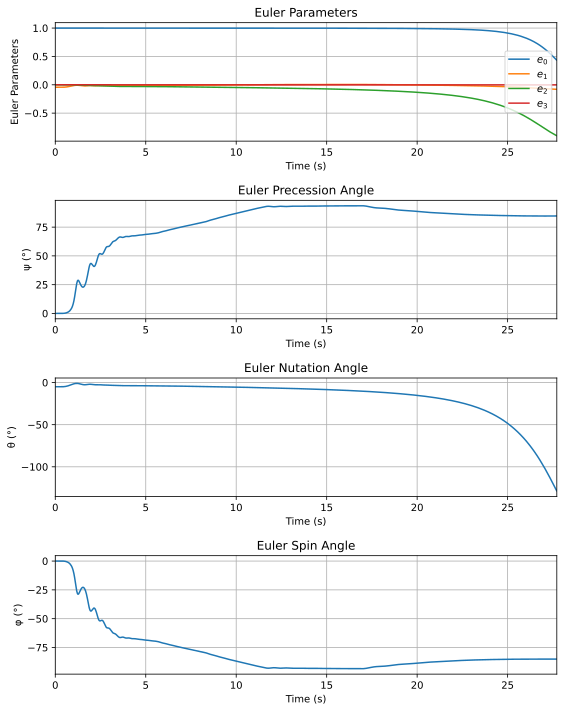



Trajectory Angular Velocity and Acceleration Plots



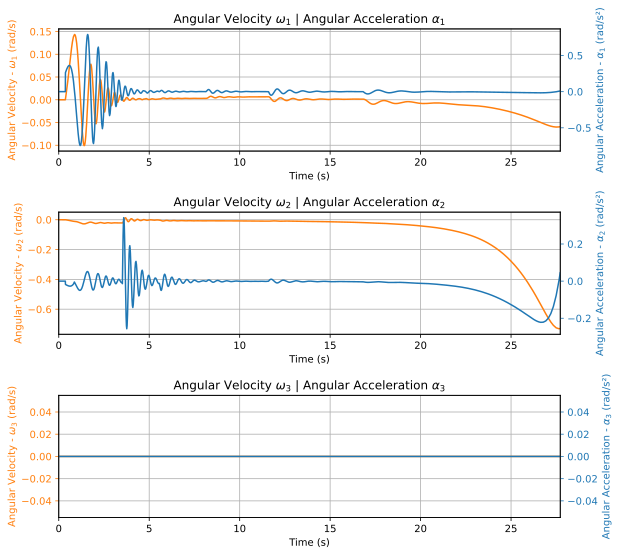



Trajectory Force Plots



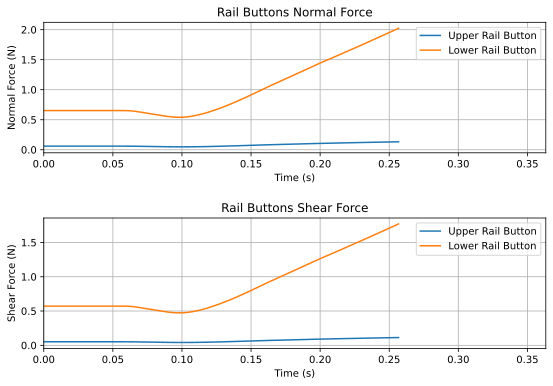

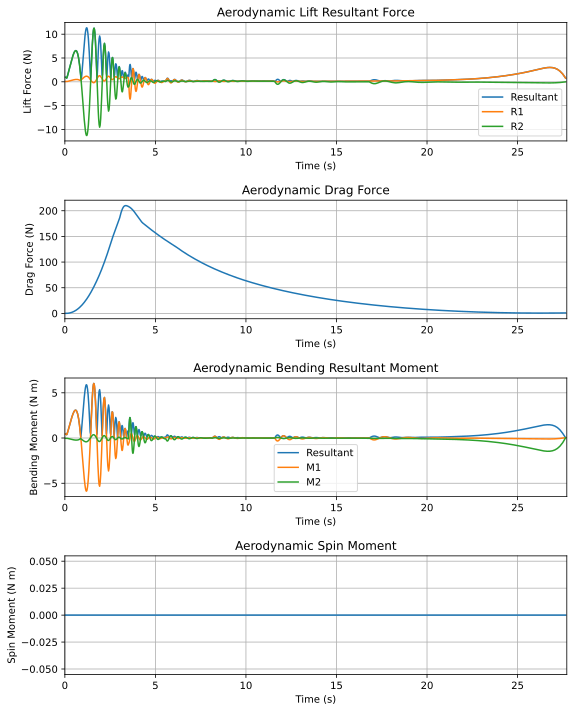



Trajectory Energy Plots



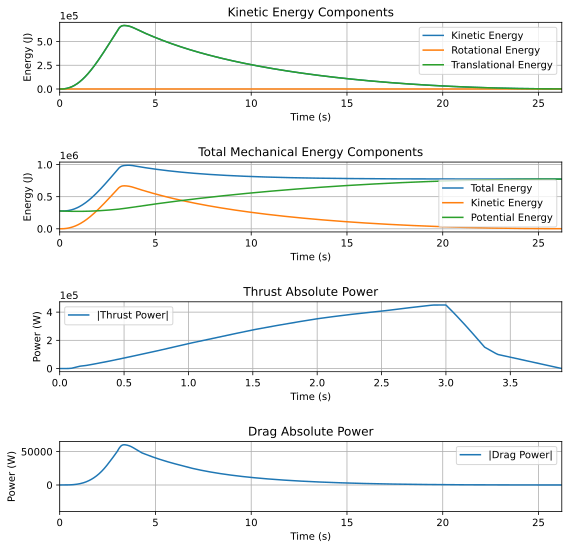



Trajectory Fluid Mechanics Plots



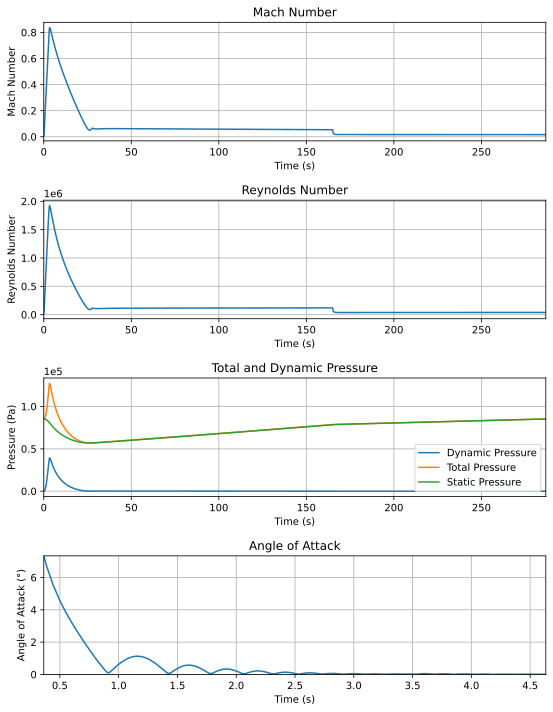



Trajectory Stability and Control Plots



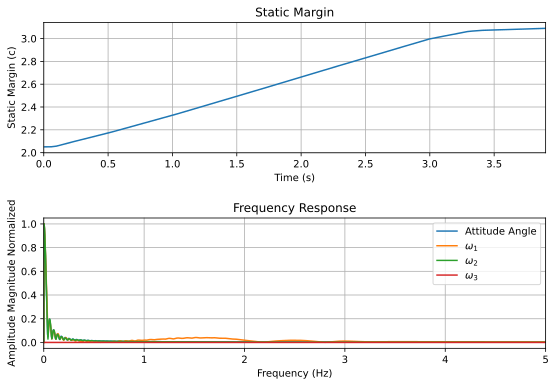

In [14]:
TestFlight.allInfo()

## Using Simulation for Design

Here, we go through a couple of examples which make use of RockePy in cool ways to help us design our rocket.

### Dynamic Stability Analysis

Ever wondered how static stability translates into dynamic stability? Different static margins result in different dynamic behaviour, which also depends on the rocket's rotational inertial.

Let's make use of RocketPy's helper class called Function to explore how the dynamic stability of Calisto varies if we change the fins span by a certain factor.

Simulating Rocket with Static Margin of -1.444->-0.405 c
Simulation Completed at Time: 5.0000 s
Simulating Rocket with Static Margin of -0.046->0.993 c
Simulation Completed at Time: 5.0000 s
Simulating Rocket with Static Margin of 1.352->2.391 c
Simulation Completed at Time: 5.0000 s
Simulating Rocket with Static Margin of 2.750->3.789 c
Simulation Completed at Time: 5.0000 s
Simulating Rocket with Static Margin of 4.147->5.186 c
Simulation Completed at Time: 5.0000 s


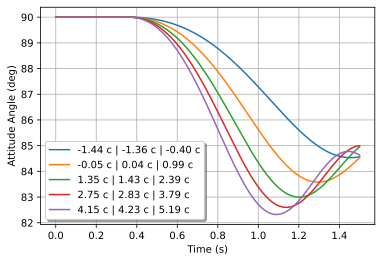

In [15]:
# Helper class
from rocketpy import Function

# Prepare Rocket Class
Calisto = Rocket(motor=Pro75M1670,
                     radius=127/2000,
                     mass=19.197-2.956,
                     inertiaI=6.60,
                     inertiaZ=0.0351,
                     distanceRocketNozzle=-1.255,
                     distanceRocketPropellant=-0.85704,
                     powerOffDrag='../../data/calisto/powerOffDragCurve.csv',
                     powerOnDrag='../../data/calisto/powerOnDragCurve.csv')
Calisto.setRailButtons([0.2, -0.5])
Nose = Calisto.addNose(length=0.55829, kind="vonKarman", distanceToCM=0.71971)
FinSet = Calisto.addFins(4, span=0.1, rootChord=0.120, tipChord=0.040, distanceToCM=-1.04956)
Tail = Calisto.addTail(topRadius=0.0635, bottomRadius=0.0435, length=0.060, distanceToCM=-1.194656)

# Prepare Environment Class
Env = Environment(5.2, 9.8)
Env.setAtmosphericModel(type='CostumAtmosphere', wind_v=-5)

# Simulate Different Static Margins by Varying Fin Position
simulation_results = []

for factor in [0.5, 0.7, 0.9, 1.1, 1.3]:
    # Modify rocket fin set by removing previous one and adding new one
    Calisto.aerodynamicSurfaces.remove(FinSet)
    FinSet = Calisto.addFins(4, span=0.1, rootChord=0.120, tipChord=0.040, distanceToCM=-1.04956*factor)
    # Simulate
    print('Simulating Rocket with Static Margin of {:1.3f}->{:1.3f} c'.format(Calisto.staticMargin(0), Calisto.staticMargin(Calisto.motor.burnOutTime)))
    TestFlight = Flight(rocket=Calisto, environment=Env, inclination=90, heading=0, maxTimeStep=0.01, maxTime=5, terminateOnApogee=True, verbose=True)
    # Post process flight data
    TestFlight.postProcess()
    # Store Results
    staticMarginAtIginition = Calisto.staticMargin(0)
    staticMarginAtOutOfRail = Calisto.staticMargin(TestFlight.outOfRailTime)
    staticMarginAtSteadyState = Calisto.staticMargin(TestFlight.tFinal)
    simulation_results += [(TestFlight.attitudeAngle, '{:1.2f} c | {:1.2f} c | {:1.2f} c'.format(staticMarginAtIginition, staticMarginAtOutOfRail, staticMarginAtSteadyState))]

Function.comparePlots(simulation_results, lower=0, upper=1.5, xlabel='Time (s)', ylabel='Attitude Angle (deg)')

### Characteristic Frequency Calculation

Here we analyse the characterist frequency of oscilation of our rocket just as it leaves the launch rail. Note that when we ran TestFlight.allInfo(), one of the plots already showed us the frequency spectrum of our flight. Here, however, we have more control of what we are plotting.

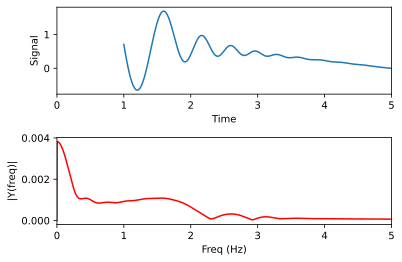

In [16]:
import numpy as np
import matplotlib.pyplot as plt

Env = Environment(
    railLength=5.2,
    latitude=32.990254,
    longitude=-106.974998,
    elevation=1400
) 

Env.setAtmosphericModel(type='CostumAtmosphere', wind_v=-5)

# Prepare Motor
Pro75M1670 = SolidMotor(
    thrustSource="../../data/motors/Cesaroni_M1670.eng",
    burnOut=3.9,
    grainNumber=5,
    grainSeparation=5/1000,
    grainDensity=1815,
    grainOuterRadius=33/1000,
    grainInitialInnerRadius=15/1000,
    grainInitialHeight=120/1000,
    nozzleRadius=33/1000,
    throatRadius=11/1000,
    interpolationMethod='linear'
)

# Prepare Rocket
Calisto = Rocket(
    motor=Pro75M1670,
    radius=127/2000,
    mass=19.197-2.956,
    inertiaI=6.60,
    inertiaZ=0.0351,
    distanceRocketNozzle=-1.255,
    distanceRocketPropellant=-0.85704,
    powerOffDrag='../../data/calisto/powerOffDragCurve.csv',
    powerOnDrag='../../data/calisto/powerOnDragCurve.csv'
)

Calisto.setRailButtons([0.2, -0.5])

Nose = Calisto.addNose(length=0.55829, kind="vonKarman", distanceToCM=0.71971)
FinSet = Calisto.addFins(4, span=0.1, rootChord=0.120, tipChord=0.040, distanceToCM=-1.04956)
Tail = Calisto.addTail(topRadius=0.0635, bottomRadius=0.0435, length=0.060, distanceToCM=-1.194656)

# Simulate first 5 seconds of Flight
TestFlight = Flight(rocket=Calisto, environment=Env, inclination=90, heading=0, maxTimeStep=0.01, maxTime=5)
TestFlight.postProcess()

# Perform a Fourier Analysis
Fs = 100.0;  # sampling rate
Ts = 1.0/Fs; # sampling interval
t = np.arange(1,400,Ts) # time vector
ff = 5;   # frequency of the signal
y = TestFlight.attitudeAngle(t) - np.mean(TestFlight.attitudeAngle(t))
n = len(y) # length of the signal
k = np.arange(n)
T = n/Fs
frq = k/T # two sides frequency range
frq = frq[range(n//2)] # one side frequency range
Y = np.fft.fft(y)/n # fft computing and normalization
Y = Y[range(n//2)]
fig, ax = plt.subplots(2, 1)
ax[0].plot(t,y)
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Signal')
ax[0].set_xlim((0, 5))
ax[1].plot(frq,abs(Y),'r') # plotting the spectrum
ax[1].set_xlabel('Freq (Hz)')
ax[1].set_ylabel('|Y(freq)|')
ax[1].set_xlim((0, 5))
plt.subplots_adjust(hspace=0.5)
plt.show()

### Apogee as a Function of Mass

This one is a classic one! We always need to know how much our rocket's apogee will change when our payload gets havier.

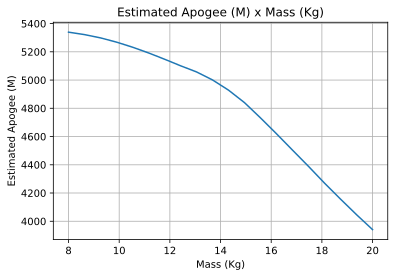

In [17]:
def apogee(mass):
    # Prepare Environment
    Env = Environment(
        railLength=5.2,
        latitude=32.990254,
        longitude=-106.974998,
        elevation=1400,
        date=(2018, 6, 20, 18)
    )
    
    Env.setAtmosphericModel(type='CostumAtmosphere', wind_v=-5)

    # Prepare Motor
    Pro75M1670 = SolidMotor(
        thrustSource="../../data/motors/Cesaroni_M1670.eng",
        burnOut=3.9,
        grainNumber=5,
        grainSeparation=5/1000,
        grainDensity=1815,
        grainOuterRadius=33/1000,
        grainInitialInnerRadius=15/1000,
        grainInitialHeight=120/1000,
        nozzleRadius=33/1000,
        throatRadius=11/1000,
        interpolationMethod='linear'
    )

    # Prepare Rocket
    Calisto = Rocket(
        motor=Pro75M1670,
        radius=127/2000,
        mass=mass,
        inertiaI=6.60,
        inertiaZ=0.0351,
        distanceRocketNozzle=-1.255,
        distanceRocketPropellant=-0.85704,
        powerOffDrag='../../data/calisto/powerOffDragCurve.csv',
        powerOnDrag='../../data/calisto/powerOnDragCurve.csv'
    )
    
    Calisto.setRailButtons([0.2, -0.5])
    Nose = Calisto.addNose(length=0.55829, kind="vonKarman", distanceToCM=0.71971)
    FinSet = Calisto.addFins(4, span=0.1, rootChord=0.120, tipChord=0.040, distanceToCM=-1.04956)
    Tail = Calisto.addTail(topRadius=0.0635, bottomRadius=0.0435, length=0.060, distanceToCM=-1.194656)

    # Simulate Flight until Apogee
    TestFlight = Flight(rocket=Calisto, environment=Env, inclination=85, heading=0, terminateOnApogee=True)
    return TestFlight.apogee

apogeebymass = Function(apogee, inputs="Mass (kg)", outputs="Estimated Apogee (m)")
apogeebymass.plot(8,20,20)

### Out of Rail Speed as a Function of Mass

To finish off, lets make a really important plot. Out of rail speed is the speed our rocket has when it is leaving the launch rail. This is crucial to make sure it can fly safely after leaving the rail. A common rule of thumb is that our rocket's out of rail speed should be 4 times the wind speed so that it does not stall and become unstable.

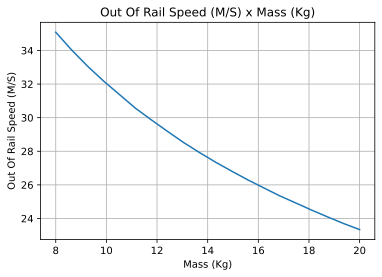

In [18]:
def speed(mass):
    # Prepare Environment
    Env = Environment(
        railLength=5.2,
        latitude=32.990254,
        longitude=-106.974998,
        elevation=1400,
        date=(2018, 6, 20, 18)
    )
    
    Env.setAtmosphericModel(type='CostumAtmosphere', wind_v=-5)

    # Prepare Motor
    Pro75M1670 = SolidMotor(
        thrustSource="../../data/motors/Cesaroni_M1670.eng",
        burnOut=3.9,
        grainNumber=5,
        grainSeparation=5/1000,
        grainDensity=1815,
        grainOuterRadius=33/1000,
        grainInitialInnerRadius=15/1000,
        grainInitialHeight=120/1000,
        nozzleRadius=33/1000,
        throatRadius=11/1000,
        interpolationMethod='linear'
    )

    # Prepare Rocket
    Calisto = Rocket(
        motor=Pro75M1670,
        radius=127/2000,
        mass=mass,
        inertiaI=6.60,
        inertiaZ=0.0351,
        distanceRocketNozzle=-1.255,
        distanceRocketPropellant=-0.85704,
        powerOffDrag='../../data/calisto/powerOffDragCurve.csv',
        powerOnDrag='../../data/calisto/powerOnDragCurve.csv'
    )
    
    Calisto.setRailButtons([0.2, -0.5])
    Nose = Calisto.addNose(length=0.55829, kind="vonKarman", distanceToCM=0.71971)
    FinSet = Calisto.addFins(4, span=0.1, rootChord=0.120, tipChord=0.040, distanceToCM=-1.04956)
    Tail = Calisto.addTail(topRadius=0.0635, bottomRadius=0.0435, length=0.060, distanceToCM=-1.194656)

    # Simulate Flight until Apogee
    TestFlight = Flight(rocket=Calisto, environment=Env, inclination=85, heading=0, terminateOnApogee=True)
    return TestFlight.outOfRailVelocity

speedbymass = Function(speed, inputs="Mass (kg)", outputs="Out of Rail Speed (m/s)")
speedbymass.plot(8,20,20)

Monte Carlo Analysis


In [19]:
!git clone https://github.com/giovaniceotto/RocketPy.git
import os
os.chdir('RocketPy/docs/notebooks/dispersion_analysis')

Cloning into 'RocketPy'...
remote: Enumerating objects: 1567, done.
remote: Counting objects: 100% (756/756), done.
remote: Compressing objects: 100% (501/501), done.
remote: Total 1567 (delta 433), reused 510 (delta 238), pack-reused 811
Receiving objects: 100% (1567/1567), 410.57 MiB | 27.38 MiB/s, done.
Resolving deltas: 100% (910/910), done.
Checking out files: 100% (119/119), done.


Installing and Load Necessary Libraries

In [20]:
!pip install netCDF4
!pip install rocketpy

In [21]:
from datetime import datetime
from time import process_time, perf_counter, time
import glob

from rocketpy import Environment, SolidMotor, Rocket, Flight, Function

import numpy as np
from numpy.random import normal, uniform, choice
from IPython.display import display

In [22]:
%config InlineBackend.figure_formats = ['svg']
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rcParams['figure.figsize'] = [8, 5]
mpl.rcParams['figure.dpi'] = 120
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['figure.titlesize'] = 14

Defining Analysis Parameters

In [23]:
analysis_parameters = {
    # Mass Details
    "rocketMass": (8.257, 0.001), # Rocket's dry mass (kg) and its uncertainty (standard deviation)

    # Propulsion Details - run help(SolidMotor) for more information
    "impulse": (1415.15, 35.3),                         # Motor total impulse (N*s)
    "burnOut": (5.274, 1),                              # Motor burn out time (s)
    "nozzleRadius": (21.642/1000, 0.5/1000),            # Motor's nozzle radius (m)
    "throatRadius": (8/1000, 0.5/1000) ,                # Motor's nozzle throat radius (m)
    "grainSeparation": (6/1000, 1/1000),                # Motor's grain separation (axial distance between two grains) (m)
    "grainDensity": (1707, 50),                         # Motor's grain density (kg/m^3)
    "grainOuterRadius": (21.4/1000, 0.375/1000),        # Motor's grain outer radius (m)
    "grainInitialInnerRadius": (9.65/1000, 0.375/1000), # Motor's grain inner radius (m)
    "grainInitialHeight": (120/1000, 1/1000),           # Motor's grain height (m)

    # Aerodynamic Details - run help(Rocket) for more information
    "inertiaI": (3.675, 0.03675),                       # Rocket's inertia moment perpendicular to its axis (kg*m^2)
    "inertiaZ": (0.007, 0.00007),                       # Rocket's inertia moment relative to its axis (kg*m^2)
    "radius": (40.45/1000, 0.001),                      # Rocket's radius (kg*m^2)
    "distanceRocketNozzle": (-1.024,0.001),             # Distance between rocket's center of dry mass and nozzle exit plane (m) (negative)
    "distanceRocketPropellant": (-0.571,0.001),         # Distance between rocket's center of dry mass and and center of propellant mass (m) (negative)
    "powerOffDrag": (0.9081/1.05, 0.033),               # Multiplier for rocket's drag curve. Usually has a mean value of 1 and a uncertainty of 5% to 10%
    "powerOnDrag": (0.9081/1.05, 0.033),                # Multiplier for rocket's drag curve. Usually has a mean value of 1 and a uncertainty of 5% to 10%
    "noseLength": (0.274, 0.001),                       # Rocket's nose cone length (m)
    "noseDistanceToCM": (1.134, 0.001),                 # Axial distance between rocket's center of dry mass and nearest point in its nose cone (m)
    "finSpan": (0.077, 0.0005),                         # Fin span (m)
    "finRootChord": (0.058, 0.0005),                    # Fin root chord (m)
    "finTipChord": (0.018, 0.0005),                     # Fin tip chord (m)
    "finDistanceToCM": (-0.906, 0.001),                 # Axial distance between rocket's center of dry mass and nearest point in its fin (m)

    # Launch and Environment Details - run help(Environment) and help(Flight) for more information
    "inclination": (84.7, 1),                           # Launch rail inclination angle relative to the horizontal plane (degrees)
    "heading": (53, 2),                                 # Launch rail heading relative to north (degrees)
    "railLength": (5.7 , 0.0005),                       # Launch rail length (m)
    "ensembleMember": list(range(10)),                  # Members of the ensemble forecast to be used

    # Parachute Details - run help(Rocket) for more information
    "CdSDrogue": (0.349*1.3, 0.07),                     # Drag coefficient times reference area for the drogue chute (m^2)
    "lag_rec": (1 , 0.5),                               # Time delay between parachute ejection signal is detected and parachute is inflated (s)

    # Electronic Systems Details - run help(Rocket) for more information
    "lag_se": (0.73, 0.16)                              # Time delay between sensor signal is received and ejection signal is fired (s)
}

Creating a Flight Settings Generator


In [24]:
def flight_settings(analysis_parameters, total_number):
    i = 0
    while i < total_number:
        # Generate a flight setting
        flight_setting = {}
        for parameter_key, parameter_value in analysis_parameters.items():
            if type(parameter_value) is tuple:
                flight_setting[parameter_key] =  normal(*parameter_value)
            else:
                flight_setting[parameter_key] =  choice(parameter_value)

        # Skip if certain values are negative, which happens due to the normal curve but isnt realistic
        if flight_setting['lag_rec'] < 0 or  flight_setting['lag_se'] < 0: continue

        # Update counter
        i += 1
        # Yield a flight setting
        yield flight_setting

Creating an Export Function

In [25]:
def export_flight_data(flight_setting, flight_data, exec_time):
    # Generate flight results
    flight_result = {"outOfRailTime": flight_data.outOfRailTime,
                 "outOfRailVelocity": flight_data.outOfRailVelocity,
                        "apogeeTime": flight_data.apogeeTime,
                    "apogeeAltitude": flight_data.apogee - Env.elevation,
                           "apogeeX": flight_data.apogeeX,
                           "apogeeY": flight_data.apogeeY,
                        "impactTime": flight_data.tFinal,
                           "impactX": flight_data.xImpact,
                           "impactY": flight_data.yImpact,
                    "impactVelocity": flight_data.impactVelocity,
               "initialStaticMargin": flight_data.rocket.staticMargin(0),
             "outOfRailStaticMargin": flight_data.rocket.staticMargin(TestFlight.outOfRailTime),
                 "finalStaticMargin": flight_data.rocket.staticMargin(TestFlight.rocket.motor.burnOutTime),
                    "numberOfEvents": len(flight_data.parachuteEvents),
                     "executionTime": exec_time}

    # Calculate maximum reached velocity
    sol = np.array(flight_data.solution)
    flight_data.vx = Function(sol[:, [0, 4]], 'Time (s)', 'Vx (m/s)', 'linear', extrapolation="natural")
    flight_data.vy = Function(sol[:, [0, 5]], 'Time (s)', 'Vy (m/s)', 'linear', extrapolation="natural")
    flight_data.vz = Function(sol[:, [0, 6]], 'Time (s)', 'Vz (m/s)', 'linear', extrapolation="natural")
    flight_data.v = (flight_data.vx**2 + flight_data.vy**2 + flight_data.vz**2)**0.5
    flight_data.maxVel = np.amax(flight_data.v.source[:, 1])
    flight_result['maxVelocity'] = flight_data.maxVel

    # Take care of parachute results
    if len(flight_data.parachuteEvents) > 0:
        flight_result['drogueTriggerTime'] = flight_data.parachuteEvents[0][0]
        flight_result['drogueInflatedTime'] = flight_data.parachuteEvents[0][0] + flight_data.parachuteEvents[0][1].lag
        flight_result['drogueInflatedVelocity'] = flight_data.v(flight_data.parachuteEvents[0][0] + flight_data.parachuteEvents[0][1].lag)
    else:
        flight_result['drogueTriggerTime'] = 0
        flight_result['drogueInflatedTime'] = 0
        flight_result['drogueInflatedVelocity'] = 0

    # Write flight setting and results to file
    dispersion_input_file.write(str(flight_setting) + '\n')
    dispersion_output_file.write(str(flight_result) + '\n')

def export_flight_error(flight_setting):
    dispersion_error_file.write(str(flight_setting) + '\n')

Simulating Each Flight Setting

In [27]:
# Basic analysis info
filename = 'dispersion_analysis_outputs/valetudo_rocket_v0'
number_of_simulations = 200

# Create data files for inputs, outputs and error logging
dispersion_error_file = open(str(filename)+'.disp_errors.txt', 'w')
dispersion_input_file = open(str(filename)+'.disp_inputs.txt', 'w')
dispersion_output_file = open(str(filename)+'.disp_outputs.txt', 'w')

# Initialize counter and timer
i = 0

initial_wall_time = time()
initial_cpu_time = process_time()

# Define basic Environment object
Env = Environment(
    railLength=5.7,
    date=(2019, 8, 10, 21),
    latitude=-23.363611,
    longitude=-48.011389
)
Env.setElevation(668)
Env.maxExpectedHeight = 1500
Env.setAtmosphericModel(
    type='Ensemble',
    file='dispersion_analysis_inputs/LASC2019_reanalysis.nc',
    dictionary="ECMWF"
)

# Set up parachutes. This rocket, named Valetudo, only has a drogue chute.
def drogueTrigger(p, y):
    # Check if rocket is going down, i.e. if it has passed the apogee
    vertical_velocity = y[5]
    # Return true to activate parachute once the vertical velocity is negative
    return True if vertical_velocity < 0 else False

# Iterate over flight settings
out = display('Starting', display_id=True)
for setting in flight_settings(analysis_parameters, number_of_simulations):
    start_time = process_time()
    i += 1

    # Update environment object
    Env.selectEnsembleMember(setting['ensembleMember'])
    Env.railLength = setting['railLength']

    # Create motor
    Keron =  SolidMotor(
        thrustSource='dispersion_analysis_inputs/thrustCurve.csv',
        burnOut=5.274,
        reshapeThrustCurve=(setting['burnOut'], setting['impulse']),
        nozzleRadius=setting['nozzleRadius'],
        throatRadius=setting['throatRadius'],
        grainNumber=6,
        grainSeparation=setting['grainSeparation'],
        grainDensity=setting['grainDensity'],
        grainOuterRadius=setting['grainOuterRadius'],
        grainInitialInnerRadius=setting['grainInitialInnerRadius'],
        grainInitialHeight=setting['grainInitialHeight'],
        interpolationMethod='linear'
    )

    # Create rocket
    Valetudo = Rocket(
        motor=Keron,
        radius=setting['radius'],
        mass=setting['rocketMass'],
        inertiaI=setting['inertiaI'],
        inertiaZ=setting['inertiaZ'],
        distanceRocketNozzle=setting['distanceRocketNozzle'],
        distanceRocketPropellant=setting['distanceRocketPropellant'],
        powerOffDrag='dispersion_analysis_inputs/Cd_PowerOff.csv',
        powerOnDrag='dispersion_analysis_inputs/Cd_PowerOn.csv'
    )
    Valetudo.setRailButtons([0.224, -0.93], 30)
    # Edit rocket drag
    Valetudo.powerOffDrag *= setting["powerOffDrag"]
    Valetudo.powerOnDrag *= setting["powerOnDrag"]
    # Add rocket nose, fins and tail
    NoseCone = Valetudo.addNose(
        length=setting['noseLength'],
        kind='vonKarman',
        distanceToCM=setting['noseDistanceToCM']
    )
    FinSet = Valetudo.addFins(
        n=3,
        rootChord=setting['finRootChord'],
        tipChord=setting['finTipChord'],
        span=setting['finSpan'],
        distanceToCM=setting['finDistanceToCM']
    )
    # Add parachute
    Drogue = Valetudo.addParachute(
        'Drogue',
        CdS=setting['CdSDrogue'],
        trigger=drogueTrigger,
        samplingRate=105,
        lag=setting['lag_rec'] + setting['lag_se'],
        noise=(0, 8.3, 0.5)
    )

    # Run trajectory simulation
    try:
        TestFlight = Flight(
            rocket=Valetudo,
            environment=Env,
            inclination=setting['inclination'],
            heading=setting['heading'],
            maxTime=600
        )
        export_flight_data(setting, TestFlight, process_time() - start_time)
    except Exception as E:
        print(E)
        export_flight_error(setting)

    # Register time
    out.update(f"Curent iteration: {i:06d} | Average Time per Iteration: {(process_time() - initial_cpu_time)/i:2.6f} s")

# Done

## Print and save total time
final_string = f"Completed {i} iterations successfully. Total CPU time: {process_time() - initial_cpu_time} s. Total wall time: {time() - initial_wall_time} s"
out.update(final_string)
dispersion_input_file.write(final_string + '\n')
dispersion_output_file.write(final_string + '\n')
dispersion_error_file.write(final_string + '\n')

## Close files
dispersion_input_file.close()
dispersion_output_file.close()
dispersion_error_file.close()

'Completed 200 iterations successfully. Total CPU time: 95.29655581800002 s. Total wall time: 92.77367186546326 s'

Importing Dispersion Analysis Saved Data

In [28]:
filename = 'dispersion_analysis_outputs/valetudo_rocket_v0'

# Initialize variable to store all results
dispersion_general_results = []

dispersion_results = {"outOfRailTime": [],
                  "outOfRailVelocity": [],
                         "apogeeTime": [],
                     "apogeeAltitude": [],
                            "apogeeX": [],
                            "apogeeY": [],
                         "impactTime": [],
                            "impactX": [],
                            "impactY": [],
                     "impactVelocity": [],
                "initialStaticMargin": [],
              "outOfRailStaticMargin": [],
                  "finalStaticMargin": [],
                     "numberOfEvents": [],
                        "maxVelocity": [],
                  "drogueTriggerTime": [],
                 "drogueInflatedTime": [],
             "drogueInflatedVelocity": [],
                      "executionTime": []}

# Get all dispersion results
# Get file
dispersion_output_file = open(str(filename)+'.disp_outputs.txt', 'r+')

# Read each line of the file and convert to dict
for line in dispersion_output_file:
    # Skip comments lines
    if line[0] != '{': continue
    # Eval results and store them
    flight_result = eval(line)
    dispersion_general_results.append(flight_result)
    for parameter_key, parameter_value in flight_result.items():
        dispersion_results[parameter_key].append(parameter_value)

# Close data file
dispersion_output_file.close()

# Print number of flights simulated
N = len(dispersion_general_results)
print('Number of simulations: ', N)

Number of simulations:  200


Dispersion Results

Out of Rail Time -         Mean Value: 1.087 s
Out of Rail Time - Standard Deviation: 0.190 s


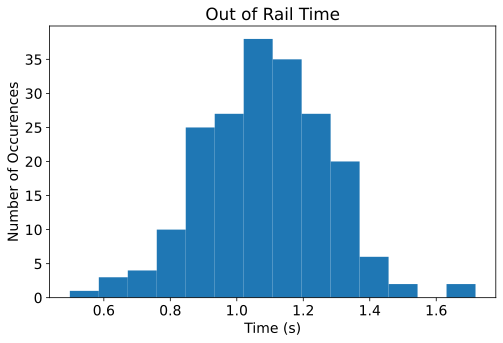

In [29]:
print(f'Out of Rail Time -         Mean Value: {np.mean(dispersion_results["outOfRailTime"]):0.3f} s')
print(f'Out of Rail Time - Standard Deviation: {np.std(dispersion_results["outOfRailTime"]):0.3f} s')

plt.figure()
plt.hist(dispersion_results["outOfRailTime"], bins=int(N**0.5))
plt.title('Out of Rail Time')
plt.xlabel('Time (s)')
plt.ylabel('Number of Occurences')
plt.show()

# You can also use Plotly instead of Matplotlib if you wish!
# import plotly.express as px
# fig1 = px.histogram(
#     x=dispersion_results["outOfRailTime"],
#     title='Out of Rail Time',
#     nbins=int(N**0.5)
# )
# fig1.update_layout(
#     xaxis_title_text='Time (s)',
#     yaxis_title_text='Number of occurences'
# )

Out of Rail Velocity

Out of Rail Velocity -         Mean Value: 23.050 m/s
Out of Rail Velocity - Standard Deviation: 3.278 m/s


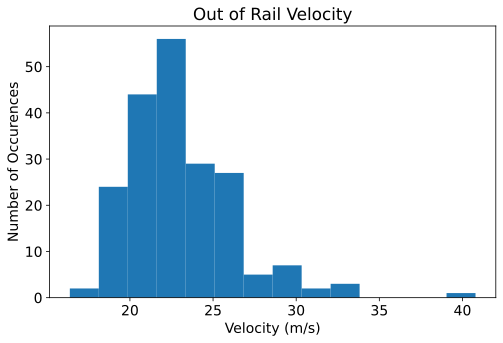

In [30]:
print(f'Out of Rail Velocity -         Mean Value: {np.mean(dispersion_results["outOfRailVelocity"]):0.3f} m/s')
print(f'Out of Rail Velocity - Standard Deviation: {np.std(dispersion_results["outOfRailVelocity"]):0.3f} m/s')

plt.figure()
plt.hist(dispersion_results["outOfRailVelocity"], bins=int(N**0.5))
plt.title('Out of Rail Velocity')
plt.xlabel('Velocity (m/s)')
plt.ylabel('Number of Occurences')
plt.show()

Apogee Time

Apogee Time -         Mean Value: 14.254 s
Apogee Time - Standard Deviation: 0.317 s


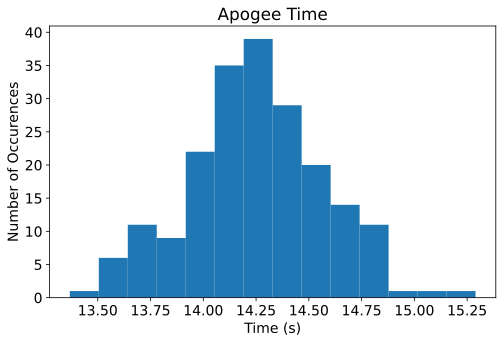

In [31]:
print(f'Apogee Time -         Mean Value: {np.mean(dispersion_results["apogeeTime"]):0.3f} s')
print(f'Apogee Time - Standard Deviation: {np.std(dispersion_results["apogeeTime"]):0.3f} s')

plt.figure()
plt.hist(dispersion_results["apogeeTime"], bins=int(N**0.5))
plt.title('Apogee Time')
plt.xlabel('Time (s)')
plt.ylabel('Number of Occurences')
plt.show()

Apogee Altitude

Apogee Altitude -         Mean Value: 841.408 m
Apogee Altitude - Standard Deviation: 45.560 m


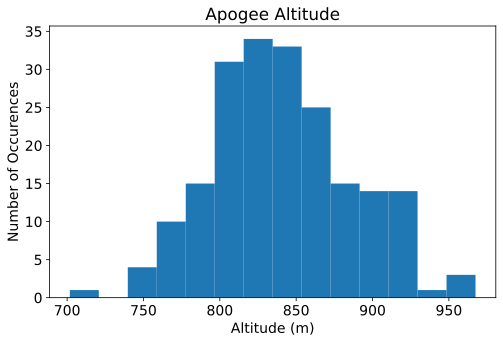

In [32]:
print(f'Apogee Altitude -         Mean Value: {np.mean(dispersion_results["apogeeAltitude"]):0.3f} m')
print(f'Apogee Altitude - Standard Deviation: {np.std(dispersion_results["apogeeAltitude"]):0.3f} m')

plt.figure()
plt.hist(dispersion_results["apogeeAltitude"], bins=int(N**0.5))
plt.title('Apogee Altitude')
plt.xlabel('Altitude (m)')
plt.ylabel('Number of Occurences')
plt.show()

Apogee X Position

Apogee X Position -         Mean Value: 104.954 m
Apogee X Position - Standard Deviation: 24.131 m


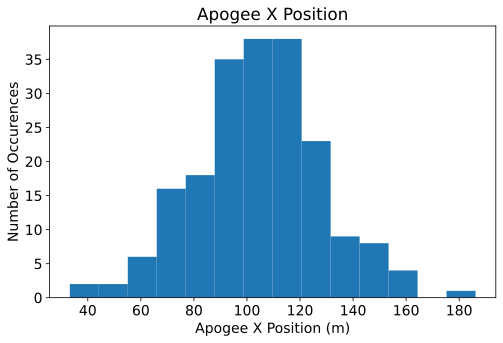

In [33]:
print(f'Apogee X Position -         Mean Value: {np.mean(dispersion_results["apogeeX"]):0.3f} m')
print(f'Apogee X Position - Standard Deviation: {np.std(dispersion_results["apogeeX"]):0.3f} m')

plt.figure()
plt.hist(dispersion_results["apogeeX"], bins=int(N**0.5))
plt.title('Apogee X Position')
plt.xlabel('Apogee X Position (m)')
plt.ylabel('Number of Occurences')
plt.show()

Impact Time

Impact Time -         Mean Value: 61.108 s
Impact Time - Standard Deviation: 3.969 s


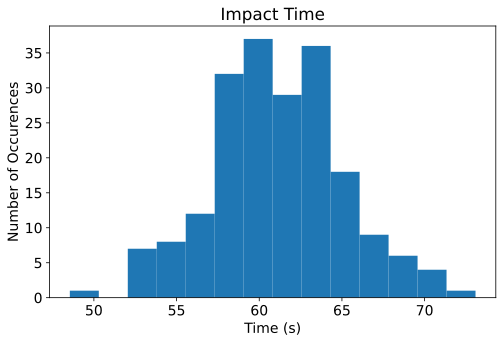

In [34]:
print(f'Impact Time -         Mean Value: {np.mean(dispersion_results["impactTime"]):0.3f} s')
print(f'Impact Time - Standard Deviation: {np.std(dispersion_results["impactTime"]):0.3f} s')

plt.figure()
plt.hist(dispersion_results["impactTime"], bins=int(N**0.5))
plt.title('Impact Time')
plt.xlabel('Time (s)')
plt.ylabel('Number of Occurences')
plt.show()

Impact X Position

Impact X Position -         Mean Value: 349.230 m
Impact X Position - Standard Deviation: 46.939 m


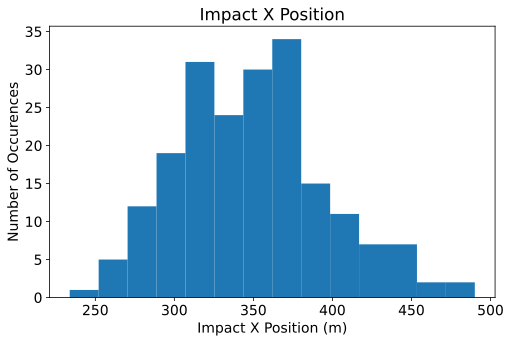

In [35]:
print(f'Impact X Position -         Mean Value: {np.mean(dispersion_results["impactX"]):0.3f} m')
print(f'Impact X Position - Standard Deviation: {np.std(dispersion_results["impactX"]):0.3f} m')

plt.figure()
plt.hist(dispersion_results["impactX"], bins=int(N**0.5))
plt.title('Impact X Position')
plt.xlabel('Impact X Position (m)')
plt.ylabel('Number of Occurences')
plt.show()

Impact Y Position

Impact Y Position -         Mean Value: 18.506 m
Impact Y Position - Standard Deviation: 35.737 m


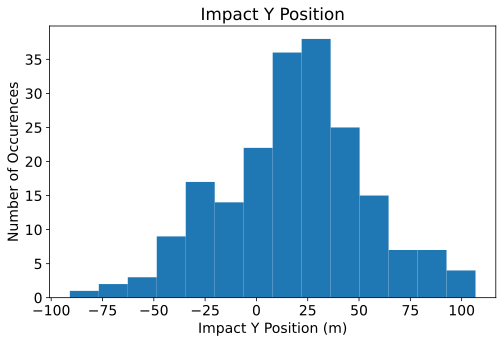

In [36]:
print(f'Impact Y Position -         Mean Value: {np.mean(dispersion_results["impactY"]):0.3f} m')
print(f'Impact Y Position - Standard Deviation: {np.std(dispersion_results["impactY"]):0.3f} m')

plt.figure()
plt.hist(dispersion_results["impactY"], bins=int(N**0.5))
plt.title('Impact Y Position')
plt.xlabel('Impact Y Position (m)')
plt.ylabel('Number of Occurences')
plt.show()

Impact Velocity

Impact Velocity -         Mean Value: -18.363 m/s
Impact Velocity - Standard Deviation: 1.466 m/s


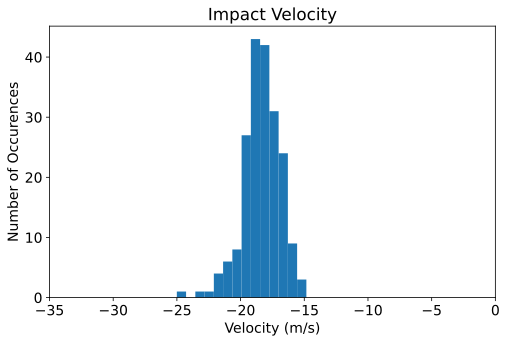

In [37]:
print(f'Impact Velocity -         Mean Value: {np.mean(dispersion_results["impactVelocity"]):0.3f} m/s')
print(f'Impact Velocity - Standard Deviation: {np.std(dispersion_results["impactVelocity"]):0.3f} m/s')

plt.figure()
plt.hist(dispersion_results["impactVelocity"], bins=int(N**0.5))
plt.title('Impact Velocity')
# plt.grid()
plt.xlim(-35,0)
plt.xlabel('Velocity (m/s)')
plt.ylabel('Number of Occurences')
plt.show()

Static Margin

Initial Static Margin -             Mean Value: 2.023 c
Initial Static Margin -     Standard Deviation: 0.367 c
Out of Rail Static Margin -         Mean Value: 2.204 c
Out of Rail Static Margin - Standard Deviation: 0.373 c
Final Static Margin -               Mean Value: 3.055 c
Final Static Margin -       Standard Deviation: 0.387 c


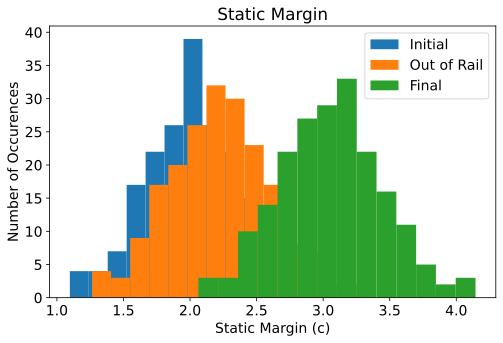

In [38]:
print(f'Initial Static Margin -             Mean Value: {np.mean(dispersion_results["initialStaticMargin"]):0.3f} c')
print(f'Initial Static Margin -     Standard Deviation: {np.std(dispersion_results["initialStaticMargin"]):0.3f} c')

print(f'Out of Rail Static Margin -         Mean Value: {np.mean(dispersion_results["outOfRailStaticMargin"]):0.3f} c')
print(f'Out of Rail Static Margin - Standard Deviation: {np.std(dispersion_results["outOfRailStaticMargin"]):0.3f} c')

print(f'Final Static Margin -               Mean Value: {np.mean(dispersion_results["finalStaticMargin"]):0.3f} c')
print(f'Final Static Margin -       Standard Deviation: {np.std(dispersion_results["finalStaticMargin"]):0.3f} c')

plt.figure()
plt.hist(dispersion_results["initialStaticMargin"], label='Initial', bins=int(N**0.5))
plt.hist(dispersion_results["outOfRailStaticMargin"], label='Out of Rail', bins=int(N**0.5))
plt.hist(dispersion_results["finalStaticMargin"], label='Final', bins=int(N**0.5))
plt.legend()
plt.title('Static Margin')
plt.xlabel('Static Margin (c)')
plt.ylabel('Number of Occurences')
plt.show()

Maximum Velocity

Maximum Velocity -         Mean Value: 124.265 m/s
Maximum Velocity - Standard Deviation: 6.176 m/s


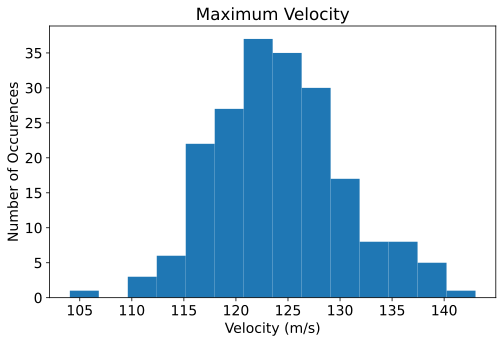

In [39]:
print(f'Maximum Velocity -         Mean Value: {np.mean(dispersion_results["maxVelocity"]):0.3f} m/s')
print(f'Maximum Velocity - Standard Deviation: {np.std(dispersion_results["maxVelocity"]):0.3f} m/s')

plt.figure()
plt.hist(dispersion_results["maxVelocity"], bins=int(N**0.5))
plt.title('Maximum Velocity')
plt.xlabel('Velocity (m/s)')
plt.ylabel('Number of Occurences')
plt.show()

Number of Parachute Events

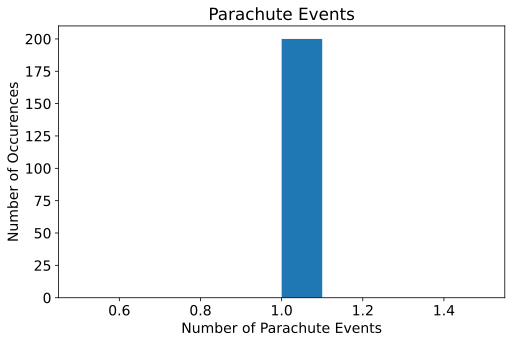

In [40]:
plt.figure()
plt.hist(dispersion_results["numberOfEvents"])
plt.title('Parachute Events')
plt.xlabel('Number of Parachute Events')
plt.ylabel('Number of Occurences')
plt.show()

Drogue Parachute Trigger Time¶

Drogue Parachute Trigger Time -         Mean Value: 14.259 s
Drogue Parachute Trigger Time - Standard Deviation: 0.317 s


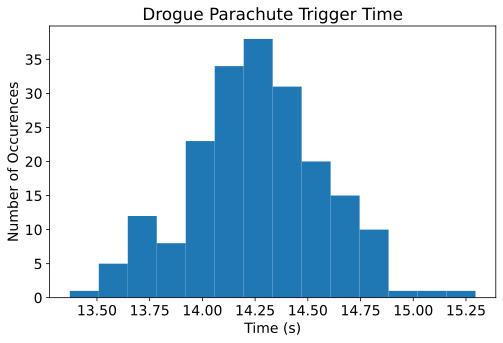

In [41]:
print(f'Drogue Parachute Trigger Time -         Mean Value: {np.mean(dispersion_results["drogueTriggerTime"]):0.3f} s')
print(f'Drogue Parachute Trigger Time - Standard Deviation: {np.std(dispersion_results["drogueTriggerTime"]):0.3f} s')

plt.figure()
plt.hist(dispersion_results["drogueTriggerTime"], bins=int(N**0.5))
plt.title('Drogue Parachute Trigger Time')
plt.xlabel('Time (s)')
plt.ylabel('Number of Occurences')
plt.show()

Drogue Parachute Fully Inflated Time

Drogue Parachute Fully Inflated Time -         Mean Value: 15.963 s
Drogue Parachute Fully Inflated Time - Standard Deviation: 0.576 s


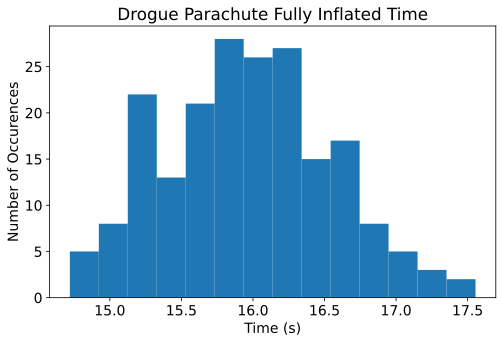

In [42]:
print(f'Drogue Parachute Fully Inflated Time -         Mean Value: {np.mean(dispersion_results["drogueInflatedTime"]):0.3f} s')
print(f'Drogue Parachute Fully Inflated Time - Standard Deviation: {np.std(dispersion_results["drogueInflatedTime"]):0.3f} s')

plt.figure()
plt.hist(dispersion_results["drogueInflatedTime"], bins=int(N**0.5))
plt.title('Drogue Parachute Fully Inflated Time')
plt.xlabel('Time (s)')
plt.ylabel('Number of Occurences')
plt.show()

Drogue Parachute Fully Inflated Velocity

Drogue Parachute Fully Inflated Velocity -         Mean Value: 19.326 m/s
Drogue Parachute Fully Inflated Velocity - Standard Deviation: 3.759 m/s


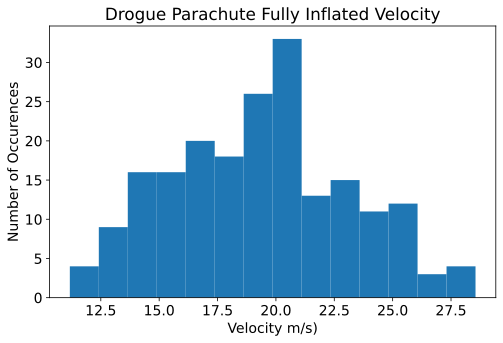

In [43]:
print(f'Drogue Parachute Fully Inflated Velocity -         Mean Value: {np.mean(dispersion_results["drogueInflatedVelocity"]):0.3f} m/s')
print(f'Drogue Parachute Fully Inflated Velocity - Standard Deviation: {np.std(dispersion_results["drogueInflatedVelocity"]):0.3f} m/s')

plt.figure()
plt.hist(dispersion_results["drogueInflatedVelocity"], bins=int(N**0.5))
plt.title('Drogue Parachute Fully Inflated Velocity')
plt.xlabel('Velocity m/s)')
plt.ylabel('Number of Occurences')
plt.show()

Error Ellipses

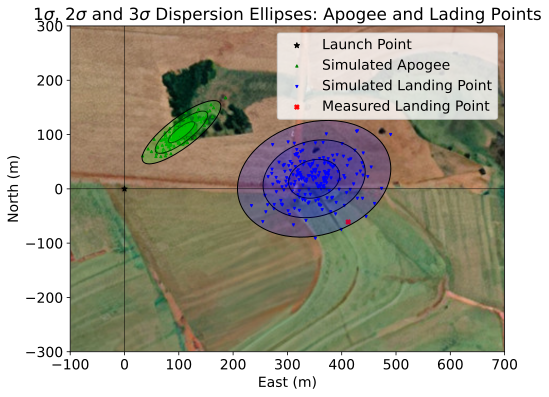

In [44]:
# Import libraries
from imageio import imread
from matplotlib.patches import Ellipse

# Import background map
img = imread("dispersion_analysis_inputs/Valetudo_basemap_final.jpg")

# Retrieve dispersion data por apogee and impact XY position
apogeeX = np.array(dispersion_results['apogeeX'])
apogeeY = np.array(dispersion_results['apogeeY'])
impactX = np.array(dispersion_results['impactX'])
impactY = np.array(dispersion_results['impactY'])

# Define function to calculate eigen values
def eigsorted(cov):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:,order]

# Create plot figure
plt.figure(num=None, figsize=(8, 6), dpi=150, facecolor='w', edgecolor='k')
ax = plt.subplot(111)

# Calculate error ellipses for impact
impactCov = np.cov(impactX, impactY)
impactVals, impactVecs = eigsorted(impactCov)
impactTheta = np.degrees(np.arctan2(*impactVecs[:,0][::-1]))
impactW, impactH = 2 * np.sqrt(impactVals)

# Draw error ellipses for impact
impact_ellipses = []
for j in [1, 2, 3]:
    impactEll = Ellipse(xy=(np.mean(impactX), np.mean(impactY)),
                  width=impactW*j, height=impactH*j,
                  angle=impactTheta, color='black')
    impactEll.set_facecolor((0, 0, 1, 0.2))
    impact_ellipses.append(impactEll)
    ax.add_artist(impactEll)

# Calculate error ellipses for apogee
apogeeCov = np.cov(apogeeX, apogeeY)
apogeeVals, apogeeVecs = eigsorted(apogeeCov)
apogeeTheta = np.degrees(np.arctan2(*apogeeVecs[:,0][::-1]))
apogeeW, apogeeH = 2 * np.sqrt(apogeeVals)

# Draw error ellipses for apogee
for j in [1, 2, 3]:
    apogeeEll = Ellipse(xy=(np.mean(apogeeX), np.mean(apogeeY)),
                  width=apogeeW*j, height=apogeeH*j,
                  angle=apogeeTheta, color='black')
    apogeeEll.set_facecolor((0, 1, 0, 0.2))
    ax.add_artist(apogeeEll)

# Draw launch point
plt.scatter(0, 0, s=30, marker='*', color='black', label='Launch Point')
# Draw apogee points
plt.scatter(apogeeX, apogeeY, s=5, marker='^', color='green', label='Simulated Apogee')
# Draw impact points
plt.scatter(impactX, impactY, s=5, marker='v', color='blue', label='Simulated Landing Point')
# Draw real landing point
plt.scatter(411.89, -61.07, s=20, marker='X', color='red', label='Measured Landing Point')

plt.legend()

# Add title and labels to plot
ax.set_title('1$\sigma$, 2$\sigma$ and 3$\sigma$ Dispersion Ellipses: Apogee and Lading Points')
ax.set_ylabel('North (m)')
ax.set_xlabel('East (m)')

# Add background image to plot
# You can translate the basemap by changing dx and dy (in meters)
dx = 0
dy = 0
plt.imshow(img,zorder=0, extent=[-1000-dx, 1000-dx, -1000-dy, 1000-dy])
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.xlim(-100, 700)
plt.ylim(-300, 300)

# Save plot and show result
plt.savefig(str(filename)+ '.pdf', bbox_inches='tight', pad_inches=0)
plt.savefig(str(filename)+ '.svg', bbox_inches='tight', pad_inches=0)
plt.show()